# Trabajo práctico 1 



In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17

## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

In [3]:
# Cargo el dataset de entrenamiento y lo separo en X e Y
path = "Datasets"
full_dataset_train = pd.read_csv(path + "/" + "HAR-train.csv")
x_train = full_dataset_train.iloc[:,:-1]
y_train = full_dataset_train["Activity"]

In [4]:
x_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,30
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,30


In [5]:
y_train

0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
7347    WALKING_UPSTAIRS
7348    WALKING_UPSTAIRS
7349    WALKING_UPSTAIRS
7350    WALKING_UPSTAIRS
7351    WALKING_UPSTAIRS
Name: Activity, Length: 7352, dtype: object

In [6]:
# Cantidad única de clases
clases = np.unique(y_train)
n_clases = len(clases)
clases

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [7]:
#Creo un dataframe de y_train para asignarle un número a cada clase
y_train_table = {
    "N": np.arange(1,len(clases)+1),
    "Clase": clases,
}
y_train_df = pd.DataFrame(y_train_table)

In [8]:
y_train_df

,N,Clase
0,1,LAYING
1,2,SITTING
2,3,STANDING
3,4,WALKING
4,5,WALKING_DOWNSTAIRS
5,6,WALKING_UPSTAIRS


In [9]:
y_train_dict = {
    clases[0]: 1,
    clases[1]: 2,
    clases[2]: 3,
    clases[3]: 4,
    clases[4]: 5,
    clases[5]: 6
}

In [10]:
y_train_dict

{'LAYING': 1,
 'SITTING': 2,
 'STANDING': 3,
 'WALKING': 4,
 'WALKING_DOWNSTAIRS': 5,
 'WALKING_UPSTAIRS': 6}

In [11]:
new_y_train = []
for i in range(0, len(y_train)):
    new_y_train.append(y_train_dict[y_train[i]])      

### Aplicamos PCA

In [12]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

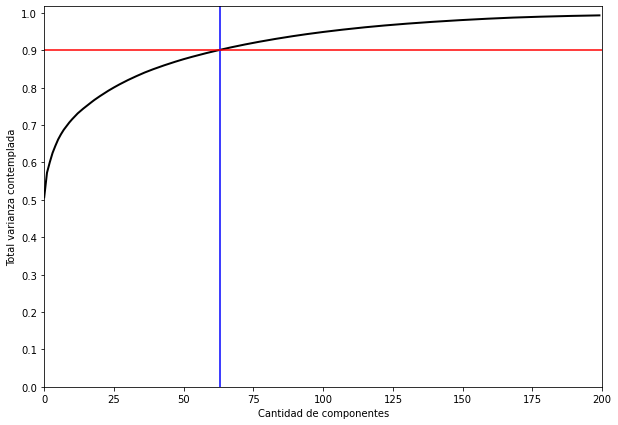

In [13]:
# Pido que me seleccione las primeraas 63 componentes y me calcule la varianza contemplada
componentes = 63

pca = PCA(n_components = componentes, random_state = RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)
pca_full = PCA(n_components = 200, random_state = RANDOM_STATE).fit(X_scaled)

varianza = np.cumsum(pca_full.explained_variance_ratio_)[componentes-1]

plt.figure(figsize = (10,7))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color = 'k', lw = 2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(componentes, c = 'b')
plt.axhline(varianza, c = 'r')
plt.show();

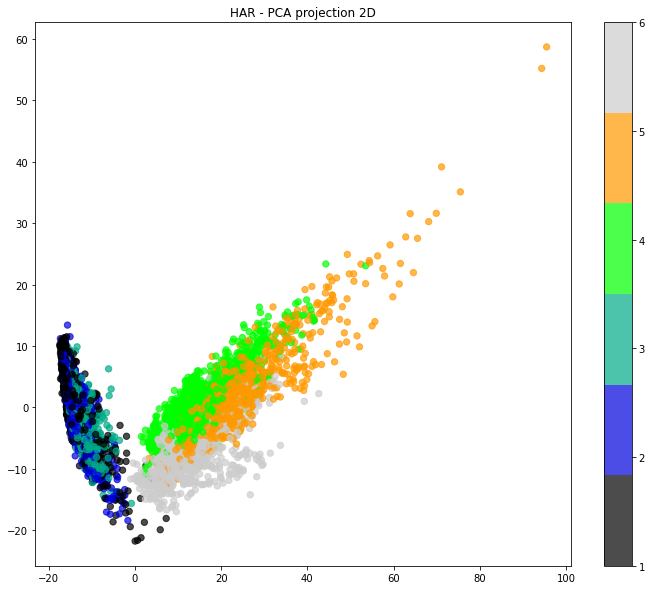

In [15]:
# Graficamos los primeros dos componentes
plt.figure(figsize = (12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = new_y_train, alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False #Evita un warning
plt.colorbar()
plt.title('HAR - PCA projection 2D');

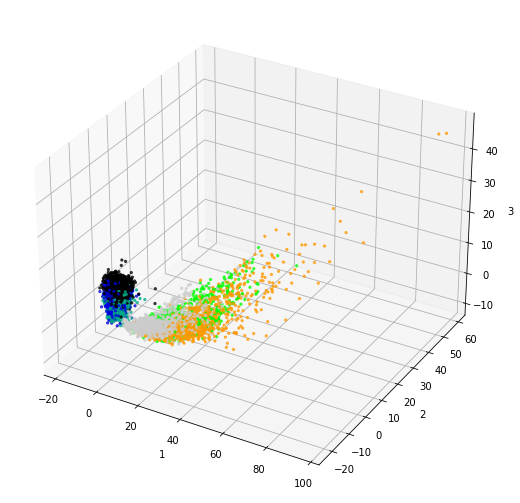

In [21]:
# Graficamos los primeros tres componentes
# El enunciado no pedía graficar en 3 dimensiones, pero me pareció interesante mostrarlo
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = new_y_train, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', 6))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

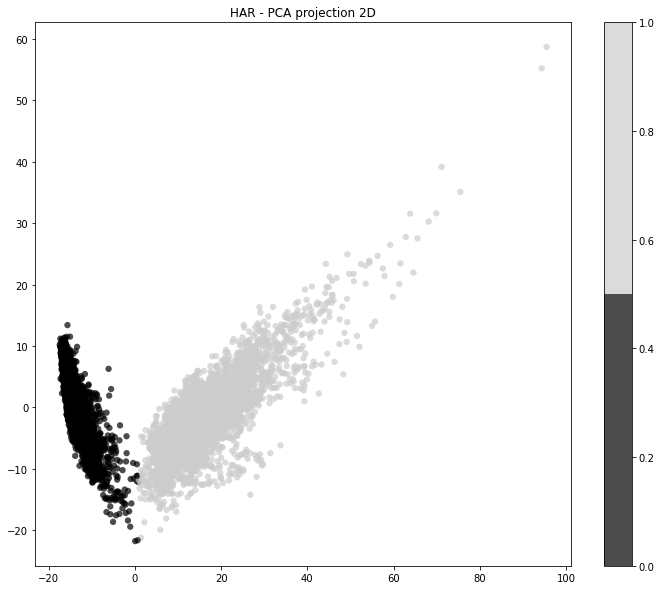

In [20]:
# Graficamos los primeros dos componentes con k = 2
kmeans_2 = KMeans(n_clusters = 2, n_init = 100, random_state = RANDOM_STATE)
kmeans_2.fit(X_pca)
cluster_labels_2 = kmeans_2.labels_

plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = cluster_labels_2, edgecolor = 'none', alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', 2))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

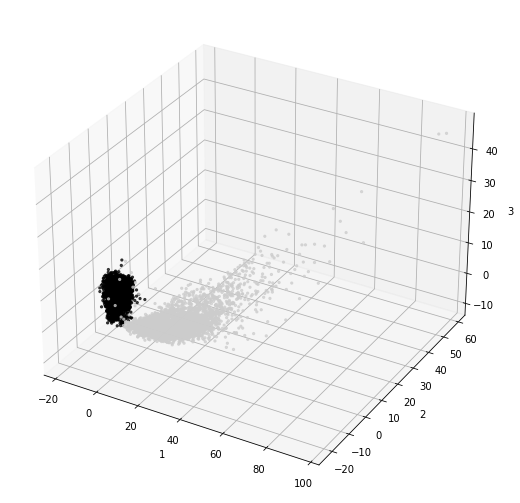

In [16]:
# Graficamos los primeros tres componentes
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = cluster_labels_2, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', 2))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

In [17]:
tab = pd.crosstab(y_train, cluster_labels_2, margins = True)
tab.index = clases.tolist() + ["ALL"]
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ["ALL"]
tab

,cluster 0,cluster 1,ALL
LAYING,1396,11,1407
SITTING,1285,1,1286
STANDING,1374,0,1374
WALKING,0,1226,1226
WALKING_DOWNSTAIRS,0,986,986
WALKING_UPSTAIRS,8,1065,1073
ALL,4063,3289,7352


Eligiendo dos clusters, el modelo separa claramente (de manera casi perfecta), las actividades que impliquen movimiento de las que no. 

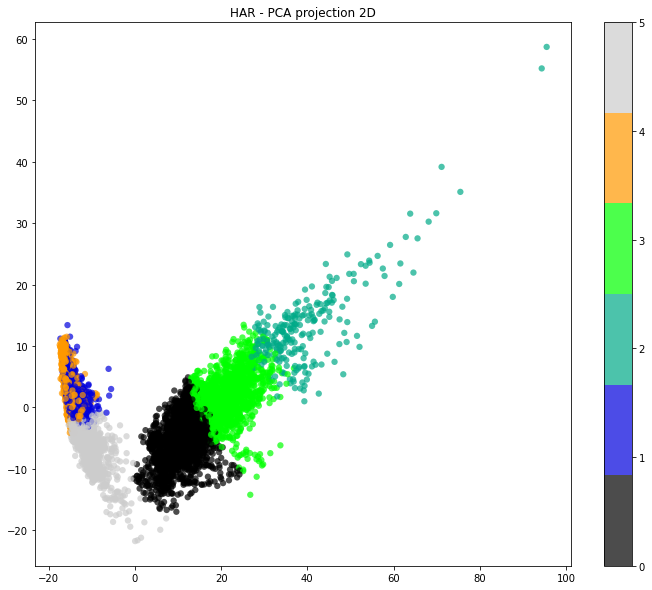

In [18]:
# Graficamos los primeros dos componentes con k = 6
kmeans_6 = KMeans(n_clusters = n_clases, n_init = 100, random_state = RANDOM_STATE)
kmeans_6.fit(X_pca)
cluster_labels_6 = kmeans_6.labels_

plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = cluster_labels_6, edgecolor = 'none', alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

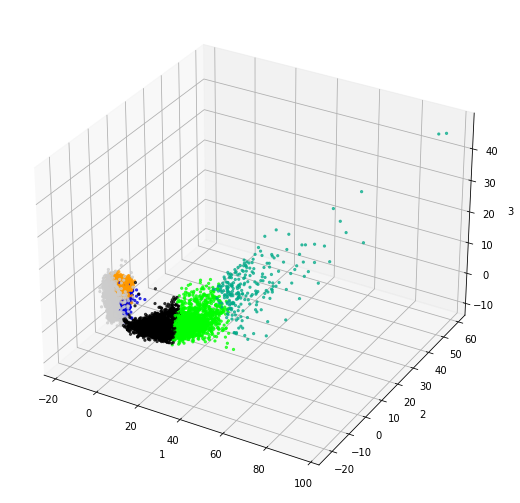

In [19]:
# Graficamos los primeros tres componentes
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = cluster_labels_6, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', 6))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

In [20]:
# Mostramos una tabla que cruza cada etiqueta real con los clusters asignados
tab = pd.crosstab(y_train, cluster_labels_6, margins = True)
tab.index = clases.tolist() + ["ALL"]
tab.columns = ['cluster ' + str(i + 0) for i in range(6)] + ["ALL"]
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,ALL
LAYING,4,26,0,0,1107,270,1407
SITTING,1,884,0,0,86,315,1286
STANDING,0,999,0,0,0,375,1374
WALKING,647,0,68,511,0,0,1226
WALKING_DOWNSTAIRS,200,0,166,620,0,0,986
WALKING_UPSTAIRS,861,0,5,205,0,2,1073
ALL,1713,1909,239,1336,1193,962,7352


Esta tabla no refleja una asignación correcta si lo que queríamos era un cluster por etiqueta. Pero de todas maneras puede notarse un patrón: los clusters 1, 4 y 5 corresonden a las actividades que no involucren movimiento, y los clusters 0, 2 y 3 corresponden a las actividades que implican movimiento. El cluster 4 es muy fuerte para la etiqueta LAYING, en donde se nota una gran diferencia con los clusters 1 y 5, que son similares para SITTING y STANDING.

In [21]:
# Vemos la inercia (suma de las distancias de los miembros de un cluster a su centroide)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
inertia

[1927.5183104042242,
 1388.194794867632,
 1293.3754813901862,
 1252.0263257843183,
 1211.0824494984122,
 1187.7062781680477,
 1169.548831750353,
 1152.3833678707826,
 1135.216767574981]

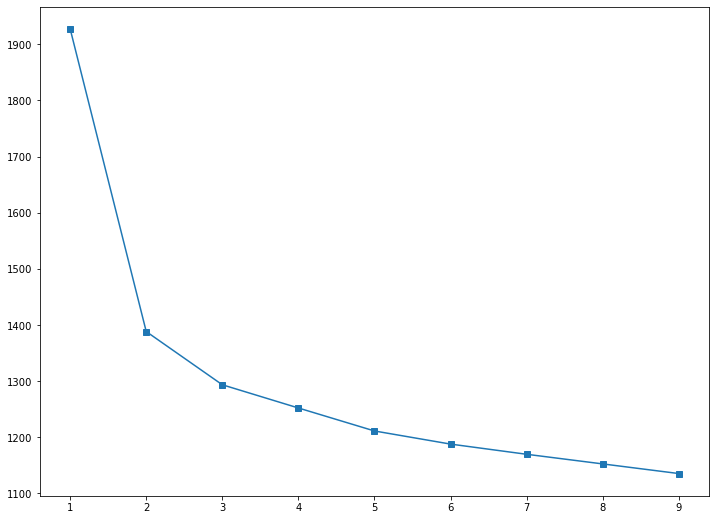

In [22]:
plt.plot(range(1, 10), inertia, marker = 's')
plt.show()

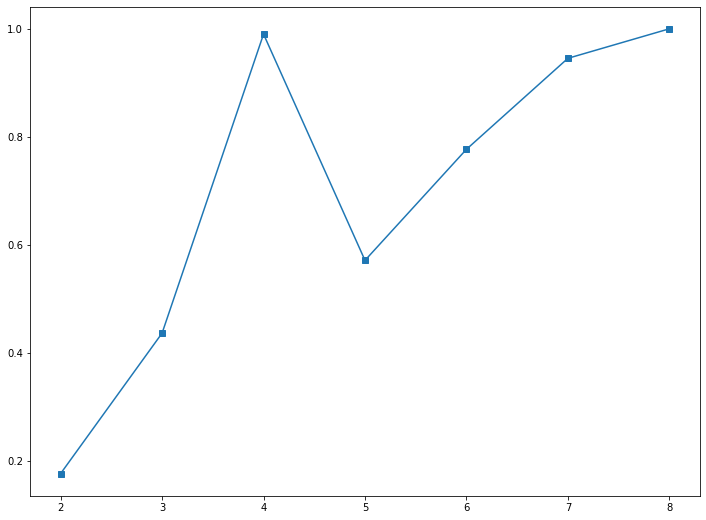

In [23]:
# Para seleccionar el mejor K (cantidad de clusters) se elige el "codo" de la función de inercia. 
# Ésta puede interpretarse como el número de clusters en donde la relación de pérdiada de inercia sea menor.

d = []
for k in range(2, 9):
    i = k - 1
    D = (inertia[i] - inertia[i + 1])  / (inertia[i - 1] - inertia[i])
    d.append(D)

plt.plot(range(2, 9), d, marker = 's')
plt.show()

In [24]:
# Para este caso, el mínimo se obtiene con K = 2.
k_opt = [round(min(d),2), np.where(d == min(d))[0][0] + 2]
k_opt

[0.18, 2]

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

* Lo que se hizo en clase y lo que se hizo es este TP fueron cosas muy similares, es por ello que se trató de agregar más análisis y comentarios en cada paso.
* Como conclusión de esta primera parte, quería decir que al elegir un k igual a la cantidad de etiquetas no siempre va a separar como nosotros quisiéramos los datos, es decir en un cluster perfecto por cada etiqueta. Esto se debe en parte a que kmeans en un algoritmo de aprendizaje no supervisado, por lo que agrupa datos semejantes en base a una distancia. El modelo nunca solicitó como información la etiqueta. Es un ejercicio muy interesante utilizar kmeans con etiquetas para ver las diferencias de asignación y entender cómo trabaja el algoritmo.